In [1]:
from common import colors, pvalue_thresholds, insetlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from scipy import stats
from sklearn.decomposition import SparsePCA, FastICA
from sklearn.svm import LinearSVC
from sklearn.neighbors import LocalOutlierFactor
from statannot import add_stat_annotation
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))

In [5]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_parameters')

# Load data

In [6]:
params = pd.read_csv(os.path.join('analysis', 'model_clustering', 'model_params.csv'))
print(params.shape)

(156, 36)


In [7]:
params.head()

,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,h_tau,lambda0,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,type
0,0.094361,5.151288,-101.0,-58.838751,6.5,-53.551984,-54.175906,5HT,0.1,0.017711,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN307,AugmentedGIF
1,0.114852,3.100761,-101.0,-78.706007,6.5,-54.555621,-52.020721,5HT,0.1,0.031279,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN308,AugmentedGIF
2,0.112754,1.247224,-101.0,-63.624398,6.5,-56.135385,-46.530925,5HT,0.1,0.070692,...,61.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN317,AugmentedGIF
3,0.087860,2.369712,-101.0,-59.121382,6.5,-55.919281,-44.936669,5HT,0.1,0.022100,...,82.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN318,AugmentedGIF
4,0.121158,4.977856,-101.0,-50.061295,6.5,-49.185461,-58.738916,5HT,0.1,0.048414,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN319,AugmentedGIF


In [8]:
params.columns

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'type'],
      dtype='object')

# Compute additional features

- Time constant
- Distance to threshold
- Spike triggered current integral
- Spike triggered threshold movement integral

In [9]:
params['thresh_dist'] = params['Vt_star'] - params['El']
params['time_const'] = params['C'] / params['gl']

In [10]:
def get_kernel_integral(model_param_df, kernel_name):
    integrals = np.zeros(model_param_df.shape[0], dtype=np.float64)
    
    for colname in model_param_df.columns:
        match = re.search('{}_(.*)'.format(kernel_name), colname)
        if match is not None:
            timescale = float(match.groups()[0])
            integrals += model_param_df[colname] * timescale
    
    return integrals

In [11]:
params['gamma_integral'] = get_kernel_integral(params, 'gamma')
params['eta_integral'] = get_kernel_integral(params, 'eta')

# Select models for each cell type and remove unnecessary features

Based on performance, use
- AugmentdGIF for 5HT
- iGIF for GABA
- GIF for mPFC

In [12]:
params_cleaned = params.copy()
params_cleaned.drop(columns=[
    'Tref', 'dt', 'E_K', 'gbar_K1', 'gbar_K2', 'h_A', 'h_Vhalf', 
    'h_k', 'lambda0', 'm_A', 'm_Vhalf', 'm_k', 'n_A', 'n_Vhalf', 
    'n_k', 'h_tau',
], inplace=True)
params_cleaned = params_cleaned.loc[
    ((params_cleaned['cell_type'] == 'mPFC') & (params_cleaned['type'] == 'GIF'))
    | ((params_cleaned['cell_type'] == '5HT') & (params_cleaned['type'] == 'AugmentedGIF'))
    | ((params_cleaned['cell_type'] == 'GABA') & (params_cleaned['type'] == 'iGIF_NP')),
    :
]
params_cleaned.drop(columns=['name', 'type'], inplace=True)

cell_types = params_cleaned['cell_type']
params_cleaned.drop(columns=['cell_type'], inplace=True)

params_cleaned.head()

,C,DV,El,Vr,Vt_star,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,eta_30.0,...,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0,gl,thresh_dist,time_const,gamma_integral,eta_integral
0,0.094361,5.151288,-58.838751,-53.551984,-54.175906,0.017711,0.034325,0.002090,0.049527,-0.008650,...,0.000675,52916.227513,-37.554494,9.206665,4.042283,0.000861,4.662845,109.635457,172510.896910,7.471629
1,0.114852,3.100761,-78.706007,-54.555621,-52.020721,0.031279,0.043995,0.006360,0.075126,-0.015343,...,-0.002653,-96.244062,83.080095,33.059678,1.568667,0.000923,26.685286,124.492827,16827.575468,5.352534
2,0.112754,1.247224,-63.624398,-56.135385,-46.530925,0.070692,0.060426,0.001846,-0.027615,-0.023437,...,-0.000825,-117.255827,105.837364,10.508601,-0.194092,0.001881,17.093473,59.930378,5393.658588,6.973327
3,0.087860,2.369712,-59.121382,-55.919281,-44.936669,0.022100,0.063368,0.001838,-0.016104,-0.006823,...,-0.000031,-24.228887,17.273688,15.561781,-0.851033,0.001263,14.184713,69.570506,2560.958939,7.348761
4,0.121158,4.977856,-50.061295,-49.185461,-58.738916,0.048414,0.021002,0.005247,-0.085554,0.010993,...,-0.004682,1136.502463,-7.241190,0.173663,2.356287,0.001390,-8.677621,87.132521,10313.230576,-6.387377


In [13]:
print(params_cleaned.columns)

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl',
       u'thresh_dist', u'time_const', u'gamma_integral', u'eta_integral'],
      dtype='object')


In [14]:
print(params_cleaned.shape)

(39, 21)


In [17]:
params_cleaned.groupby(cell_types).mean().loc[:, ['thresh_dist', 'time_const', 'gamma_integral', 'eta_integral']]

,thresh_dist,time_const,gamma_integral,eta_integral
cell_type,,,,
5HT,12.087814,82.505639,8.460469e+06,6.175051
GABA,7.486579,37.816230,7.953363e+02,0.215101
mPFC,3.977570,41.955724,8.707739e+02,2.747578


In [18]:
params_cleaned.groupby(cell_types).std().loc[:, ['thresh_dist', 'time_const', 'gamma_integral', 'eta_integral']]

,thresh_dist,time_const,gamma_integral,eta_integral
cell_type,,,,
5HT,10.577009,30.968535,2.170914e+07,4.317218
GABA,9.355018,21.807854,7.796334e+02,2.084112
mPFC,10.266719,34.308788,7.180134e+02,1.832729


In [19]:
params_cleaned.groupby(cell_types).count().loc[:, ['thresh_dist', 'time_const', 'gamma_integral', 'eta_integral']]

,thresh_dist,time_const,gamma_integral,eta_integral
cell_type,,,,
5HT,18,18,18,18
GABA,14,14,14,14
mPFC,7,7,7,7


# Functions for rescaling variables

In [15]:
def rescale_variables(x):
    """Subtract mean and normalize to SD for each column of a dataframe or array.
    Returns a copy.
    """
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.mean(output[colname])
            output[colname] = output[colname] / np.std(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.mean(axis = 0)
        output /= output.std(axis = 0)
        
    return output

In [16]:
def rescale_variables_nonparametric(x):
    """Subtract median and divide by interquartile range for each column of x."""
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.median(output[colname])
            output[colname] = output[colname] / stats.iqr(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.median(axis = 0)
        output /= stats.iqr(output, axis=0)
        
    return output

In [17]:
rescaled = rescale_variables_nonparametric(params_cleaned)

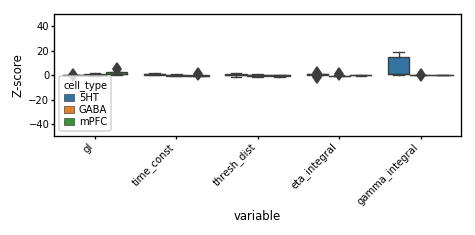

In [18]:
plt.figure(figsize=(4, 2))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gl', 'time_const', 'thresh_dist', 'eta_integral', 'gamma_integral']
)
plt.ylim(-50, 50)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.ylabel('Z-score')
plt.tight_layout()

In [19]:
figsize=(1, 1.2)

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
thresh_dist_5HT v.s. thresh_dist_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.874e-01 U_stat=1.560e+02
thresh_dist_GABA v.s. thresh_dist_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.600e+01
thresh_dist_5HT v.s. thresh_dist_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.648e-01 U_stat=8.700e+01


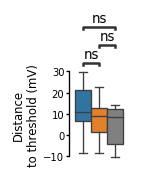

In [20]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['thresh_dist'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['thresh_dist'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('thresh_dist', '5HT'), ('thresh_dist', 'GABA')),
        (('thresh_dist', 'mPFC'), ('thresh_dist', 'GABA')),
        (('thresh_dist', '5HT'), ('thresh_dist', 'mPFC'))
    ]
)
plt.ylabel('Distance\nto threshold (mV)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'thresh_dist.png'))
    plt.savefig(os.path.join(IMG_PATH, 'thresh_dist.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
DV_5HT v.s. DV_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.374e-04 U_stat=2.240e+02
DV_GABA v.s. DV_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.597e-02 U_stat=1.600e+01
DV_5HT v.s. DV_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.300e+01


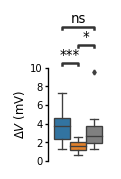

In [21]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['DV'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['DV'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('DV', '5HT'), ('DV', 'GABA')),
        (('DV', 'mPFC'), ('DV', 'GABA')),
        (('DV', '5HT'), ('DV', 'mPFC'))
    ]
)
plt.ylabel(r'$\Delta V$ (mV)')
plt.yticks([0, 2, 4, 6, 8, 10])
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'thresh_width.png'))
    plt.savefig(os.path.join(IMG_PATH, 'thresh_width.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
time_const_5HT v.s. time_const_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.374e-04 U_stat=2.240e+02
time_const_GABA v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.000e+01
time_const_5HT v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.031e-02 U_stat=1.060e+02


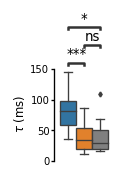

In [22]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['time_const'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['time_const'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('time_const', '5HT'), ('time_const', 'GABA')),
        (('time_const', 'mPFC'), ('time_const', 'GABA')),
        (('time_const', '5HT'), ('time_const', 'mPFC'))
    ]
)
plt.ylabel(r'$\tau$ (ms)')
plt.yticks([0, 50, 100, 150])
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'time_const.png'))
    plt.savefig(os.path.join(IMG_PATH, 'time_const.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
eta_integral_5HT v.s. eta_integral_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.483e-04 U_stat=2.250e+02
eta_integral_GABA v.s. eta_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.426e-02 U_stat=1.300e+01
eta_integral_5HT v.s. eta_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.123e-02 U_stat=1.080e+02


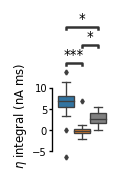

In [23]:
plt.figure(figsize=figsize)

eta_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    eta_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('eta_integral', '5HT'), ('eta_integral', 'GABA')),
        (('eta_integral', 'mPFC'), ('eta_integral', 'GABA')),
        (('eta_integral', '5HT'), ('eta_integral', 'mPFC'))
    ]
)
plt.ylabel('$\eta$ integral (nA ms)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'eta_integral.png'))
    plt.savefig(os.path.join(IMG_PATH, 'eta_integral.svg'))

Some 5HT neurons have **huge** moving thresholds. For clarity, we won't plot these.

In [24]:
params_cleaned[cell_types == '5HT']['gamma_integral'] > 200e3

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12    False
13    False
14    False
15     True
16    False
17    False
Name: gamma_integral, dtype: bool

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_integral_5HT v.s. gamma_integral_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.840e-05 U_stat=2.380e+02
gamma_integral_GABA v.s. gamma_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.200e+01
gamma_integral_5HT v.s. gamma_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.882e-03 U_stat=1.200e+02


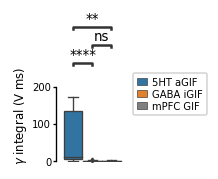

In [25]:
gamma_integrals = pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type')
gamma_integrals['value'] *= 1e-3  # Convert mV to V
gamma_integrals_outliers_removed = gamma_integrals.loc[gamma_integrals['value'] < 25, :]

plt.figure(figsize=(1.5, figsize[1]))

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=gamma_integrals,
    order = ['gamma_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
plt.ylim(-2, 250)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gamma_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('gamma_integral', '5HT'), ('gamma_integral', 'GABA')),
        (('gamma_integral', 'mPFC'), ('gamma_integral', 'GABA')),
        (('gamma_integral', '5HT'), ('gamma_integral', 'mPFC'))
    ]
)
plt.ylabel('$\gamma$ integral (V ms)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
pltools.hide_border('trb')
legend_labels = plt.legend(bbox_to_anchor=(1, 1), loc='upper left').get_texts()
legend_labels[0].set_text(legend_labels[0].get_text() + ' aGIF')
legend_labels[1].set_text(legend_labels[1].get_text() + ' iGIF')
legend_labels[2].set_text(legend_labels[2].get_text() + ' GIF')


plt.subplots_adjust(left=0.2, top=0.7, bottom=0.05, right=0.6)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral.svg'))

Three 5HT neurons have moving threshold integral >200,000 mV ms and are not shown. Significance is for the whole sample, but doesn't change (stays within a p-value interval) when those points are omitted (see below).

In [26]:
stats.mannwhitneyu(
    gamma_integrals_outliers_removed.loc[
        (gamma_integrals_outliers_removed['cell_type'] == '5HT')
        & (gamma_integrals_outliers_removed['variable'] == 'gamma_integral'),
        'value'
    ],
    gamma_integrals_outliers_removed.loc[
        (gamma_integrals_outliers_removed['cell_type'] == 'GABA')
        & (gamma_integrals_outliers_removed['variable'] == 'gamma_integral'),
        'value'
    ],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=168.0, pvalue=0.00020542400976060417)

In [27]:
stats.mannwhitneyu(
    gamma_integrals_outliers_removed.loc[
        (gamma_integrals_outliers_removed['cell_type'] == '5HT')
        & (gamma_integrals_outliers_removed['variable'] == 'gamma_integral'),
        'value'
    ],
    gamma_integrals_outliers_removed.loc[
        (gamma_integrals_outliers_removed['cell_type'] == 'mPFC')
        & (gamma_integrals_outliers_removed['variable'] == 'gamma_integral'),
        'value'
    ],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=85.0, pvalue=0.0019983829447578717)